In [4]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

In [5]:
env = gym.make('Blackjack-v1', sab=True)  # https://gymnasium.farama.org/environments/toy_text/blackjack/

V = np.zeros((10, 10, 2))
returns = np.empty((10, 10, 2), dtype=object)
for i in range(10):
    for j in range(10):
        for k in range(2):
            returns[i, j, k] = []

episodes = 30000

In [6]:
FIRST_VISIT = False

for episode in tqdm(range(episodes)):

    states = []
    rewards = []

    while True:
        state, info = env.reset()
        while state[0] < 12:
            state, reward, done, truncated, info = env.step(1)
        if state[0] == 13 and state[1] == 2 and state[2] == 1:
            break

    while not done:
        if state[0] < 20:
            action = 1
        else:
            action = 0

        state_index = (state[0]-12, state[1]-1, state[2])
        states.append(state_index)

        next_state, reward, done, truncated, info = env.step(action)
        rewards.append(reward)

        state = next_state

    G = 0
    for i in reversed(range(len(states))):
        G = G + rewards[i]
        if not FIRST_VISIT or states[i] not in states[:i]:
            returns[states[i]].append(G)
            # V[states[i]] = np.mean(returns[states[i]])


100%|█████████████████████████████████████| 30000/30000 [11:58<00:00, 41.78it/s]


In [7]:
target_v_value = np.mean(returns[(1, 1, 1)])
print(target_v_value)

-0.2854799290234022


#### Ordinary importance sampling

In [8]:
env = gym.make('Blackjack-v1', sab=True)  # https://gymnasium.farama.org/environments/toy_text/blackjack/

tests = 20
episodes = 1500

In [9]:
FIRST_VISIT = False

ord_v_values = []

for tests in tqdm(range(tests)):

    ord_v_values_ = []

    V = np.zeros((10, 10, 2))
    returns = np.empty((10, 10, 2), dtype=object)
    for i in range(10):
        for j in range(10):
            for k in range(2):
                returns[i, j, k] = []

    for episode in range(episodes):

        states = []
        rewards = []
        W_ = []

        while True:
            state, info = env.reset()
            while state[0] < 12:
                state, reward, done, truncated, info = env.step(1)
            if state[0] == 13 and state[1] == 2 and state[2] == 1:
                break
            
        while not done:
            action = np.random.randint(2)

            state_index = (state[0]-12, state[1]-1, state[2])
            states.append(state_index)

            next_state, reward, done, truncated, info = env.step(action)
            rewards.append(reward)

            if state[0] < 20:
                if action == 1:
                    W_.append(2)
                else:
                    W_.append(0)
            else:
                if action == 0:
                    W_.append(2)
                else:
                    W_.append(0)

            state = next_state

        G = 0
        W = 1
        for i in reversed(range(len(states))):
            G = G + rewards[i]
            if not FIRST_VISIT or states[i] not in states[:i]:
                W *= W_[i]
                returns[states[i]].append(W*G)
                # V[states[i]] = np.mean(returns[states[i]])

        ord_v_values_.append(np.mean(returns[(1, 1, 1)]))
    ord_v_values.append(ord_v_values_)
ord_v_values_np = np.array(ord_v_values)

100%|███████████████████████████████████████████| 20/20 [11:21<00:00, 34.07s/it]


#### Weighted importance sampling

In [10]:
env = gym.make('Blackjack-v1', sab=True)  # https://gymnasium.farama.org/environments/toy_text/blackjack/

tests = 20
episodes = 1500

In [11]:
FIRST_VISIT = False

wei_v_values = []

for tests in tqdm(range(tests)):

    wei_v_values_ = []

    V = np.zeros((10, 10, 2))
    returns = np.empty((10, 10, 2), dtype=object)
    for i in range(10):
        for j in range(10):
            for k in range(2):
                returns[i, j, k] = []

    sum_W = np.zeros((10, 10, 2))

    for episode in range(episodes):

        states = []
        rewards = []
        
        W_ = []

        while True:
            state, info = env.reset()
            while state[0] < 12:
                state, reward, done, truncated, info = env.step(1)
            if state[0] == 13 and state[1] == 2 and state[2] == 1:
                break

        while not done:
            action = np.random.randint(2)

            state_index = (state[0]-12, state[1]-1, state[2])
            states.append(state_index)

            next_state, reward, done, truncated, info = env.step(action)
            rewards.append(reward)

            if state[0] < 20:
                if action == 1:
                    W_.append(2)
                else:
                    W_.append(0)
            else:
                if action == 0:
                    W_.append(2)
                else:
                    W_.append(0)

            state = next_state
        
        G = 0
        W = 1
        for i in reversed(range(len(states))):
            G = G + rewards[i]
            if not FIRST_VISIT or states[i] not in states[:i]:
                W *= W_[i]
                sum_W[states[i]] += W
                returns[states[i]].append(W*G)
                # V[states[i]] = np.mean(returns[states[i]])

        wei_v_values_.append(np.sum(returns[(1, 1, 1)])/(sum_W[(1, 1, 1)]+1e-6))
    wei_v_values.append(wei_v_values_)
wei_v_values_np = np.array(wei_v_values)

100%|███████████████████████████████████████████| 20/20 [11:36<00:00, 34.80s/it]


In [12]:
ord_v_value_error = np.mean((ord_v_values_np - target_v_value)**2, axis=0)
wei_v_value_error = np.mean((wei_v_values_np - target_v_value)**2, axis=0)

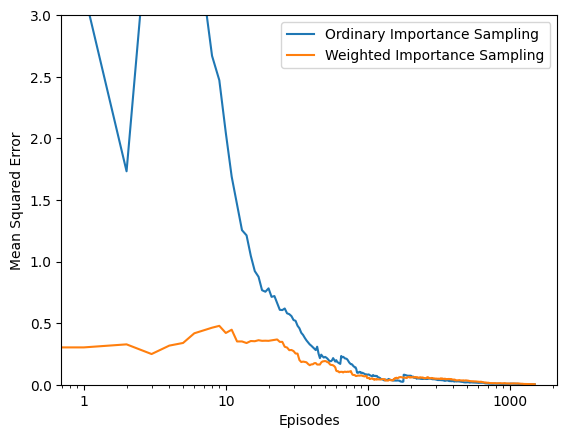

In [21]:
plt.plot(ord_v_value_error)
plt.plot(wei_v_value_error)
plt.ylim([0, 3])
plt.xscale('log')
plt.xticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plt.xlabel('Episodes')
plt.ylabel('Mean Squared Error')
plt.legend(['Ordinary Importance Sampling', 'Weighted Importance Sampling'])

plt.show()